# GeoFlood preprocessing 10m DEM data

In [1]:
"""
Return buffered digital elevation map (DEM)
 based on NFIE-defined catchments corresponding with the HUC12
 encompassing the area of interest

__author__ = "Daniel Hardesty Lewis"
__copyright__ = "Copyright 2020, Daniel Hardesty Lewis"
__credits__ = ["Daniel Hardesty Lewis"]
__license__ = "GPLv3"
__version__ = "1.0.0"
__maintainer__ = "Daniel Hardesty Lewis"
__email__ = "dhl@tacc.utexas.edu"
__status__ = "Production"
"""

'\nReturn buffered digital elevation map (DEM)\n based on NFIE-defined catchments corresponding with the HUC12\n encompassing the area of interest\n\n__author__ = "Daniel Hardesty Lewis"\n__copyright__ = "Copyright 2020, Daniel Hardesty Lewis"\n__credits__ = ["Daniel Hardesty Lewis"]\n__license__ = "GPLv3"\n__version__ = "1.0.0"\n__maintainer__ = "Daniel Hardesty Lewis"\n__email__ = "dhl@tacc.utexas.edu"\n__status__ = "Production"\n'

In [2]:
##TODO: Insert images (slides) into the MarkDown

## Import needed modules

In [1]:
import fiona
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
import os
from pathlib import Path

In [56]:
import contextily as ctx
import matplotlib.pyplot as plt
import rasterio.plot
import numpy.ma as ma

Correctly set GDAL_DATA environment variable
 (This is because Geopandas sometimes does not refer to the correct underlying libraries.)

In [3]:
oldgdal_data = os.environ['GDAL_DATA']
os.environ['GDAL_DATA'] = os.path.join(fiona.__path__[0],'gdal_data')

## Define input and output file locations

Define an empty object to consolidate all the arguments

In [4]:
args = type('', (), {})()

### Define the required input files

NHD MR GIS files with layers labelled Flowline and Catchment

In [5]:
args.nhd = "ATX/NFIEGeo_TX-ATX.gdb"

WBD HUC12 vector data

In [6]:
args.huc12 = "ATX/WBD_National_GDB-HU12-ATX.shp/WBD_National_GDB-HU12-ATX.shp"

Input vector GIS file with single polygon of the study area

In [7]:
args.shapefile = "ATX/ATX-Downtown.shp/ATX-Downtown.shp"

Input DEM file

In [8]:
args.raster = "ATX/USGS-ATX.tif"

### Check that the required input files have been defined correctly

In [9]:
if not args.shapefile:
    raise(ValueError('args.shapefile Input shapefile cutline not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.shapefile Input shapefile cutline not a string'))
if not args.huc12 or not isinstance(args.huc12, str):
    raise(ValueError('args.huc12 Input HUC12 shapefile not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.huc12 Input HUC12 shapefile not a string'))
if not args.nhd or not isinstance(args.nhd, str):
    raise(ValueError('args.nhd Input NHD geodatabase not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.nhd Input NHD geodatabase not a string'))
if not args.raster or not isinstance(args.raster, str):
    raise(ValueError('args.raster Input raster not specified'))
if not isinstance(args.shapefile, str):
    raise(TypeError('args.raster Input raster not a string'))

### Define optional arguments

Optional distance to buffer the output raster

In [10]:
args.buffer = ""

Optional directory for the output DEMs
 (The outputs will be organized by HUC)
 (If not defined, the output will be produced in the currect directory)

In [11]:
args.directory = ""

### Check that the optional input arguments have been defined correctly

In [12]:
if args.buffer and not isinstance(args.buffer, float):
    raise(TypeError('args.buffer Buffer is not a floating point number'))
if args.directory and not isinstance(args.directory, str):
    raise(TypeError('args.directory Output directory is not a string'))    

## Identify catchments and flowlines to HUCs

Find the HUC12s that intersect with the input polygon

In [13]:
shape = gpd.read_file(args.shapefile)

hu12 = gpd.read_file(args.huc12, mask=shape)
hu12 = hu12[['HUC12','geometry']]

if len(hu12)!=1:
    raise(UserWarning('We will not process more than one HUC in this tutorial'))
hu = hu12['HUC12'][0]
hu12 = hu12.iloc[[0]]

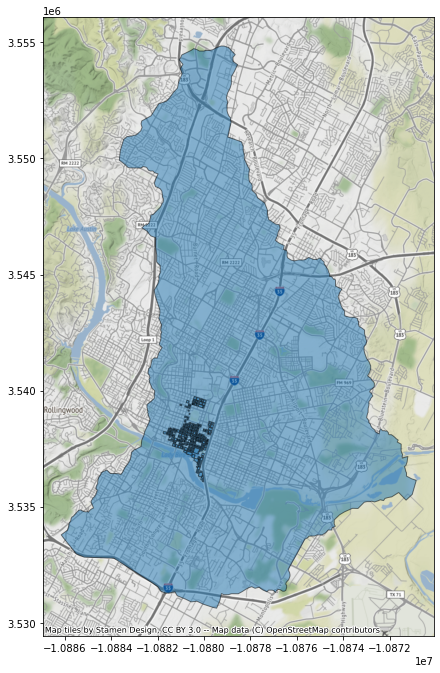

In [118]:
f, ax = plt.subplots(figsize=(7,hu12.shape[1]/hu12.shape[0]*7))
hu12.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(7,hu12.shape[1]/hu12.shape[0]*7),
    alpha=.5,
    edgecolor='k'
)
shape.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(7,hu12.shape[1]/hu12.shape[0]*7),
    alpha=.5,
    edgecolor='k'
)
ctx.add_basemap(ax)
plt.show()

Find the flowlines whose representative points are within these HUC12s

In [30]:
flows = gpd.read_file(args.nhd, layer='Flowline', mask=hu12)
flows.drop(columns=['Shape_Length','Shape_Area','AreaSqKM'],inplace=True,errors='ignore')
flows.reset_index(inplace=True)
flows.set_index('COMID',inplace=True)
flows.sort_index(inplace=True)

flows_rep = flows.copy()
flows_rep['geometry'] = flows.representative_point()
flowshu12shape_rep = gpd.sjoin(flows_rep,hu12.to_crs(flows_rep.crs),op='intersects',how='inner')
flowshu12shape_rep.drop(columns=['index_left','index_right'],errors='ignore',inplace=True)

Find the catchments corresponding with these flowlines

In [31]:
catchs = gpd.read_file(args.nhd, layer='Catchment', mask=hu12)
catchs.reset_index(inplace=True)
catchs.set_index('FEATUREID',inplace=True)
catchs.sort_index(inplace=True)

catchshu12shape = catchs[catchs.index.isin(flowshu12shape_rep.index)]

Find the flowlines corresponding with these cactchments

In [32]:
flowshu12shape = flows[flows.index.isin(catchshu12shape.index)]

Determine which HUC12s each of the flowlines and catchments belong to
 (Note: because we have guaranteed that only 1 HUC will be treated,
 this step just copies the HUC12 ID to the flowline and catchment
 geodataframes. However, writing it this way is extensible to the
 multiple-HUC case.)

In [33]:
flowshu12shape.loc[flowshu12shape.index,'HUC12'] = flowshu12shape_rep.loc[flowshu12shape.index,'HUC12']
catchshu12shape.loc[catchshu12shape.index,'HUC12'] = flowshu12shape.loc[catchshu12shape.index,'HUC12']

/Users/taccstaff/miniconda3/envs/geoflood-pre/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Absolutely ensure flowlines and catchments belong to each other

In [34]:
flowshu12shape = flowshu12shape[flowshu12shape.is_valid]
catchshu12shape = catchshu12shape[catchshu12shape.is_valid]
catchshu12shape = catchshu12shape[catchshu12shape.index.isin(flowshu12shape.index)]
flowshu12shape = flowshu12shape[flowshu12shape.index.isin(catchshu12shape.index)]

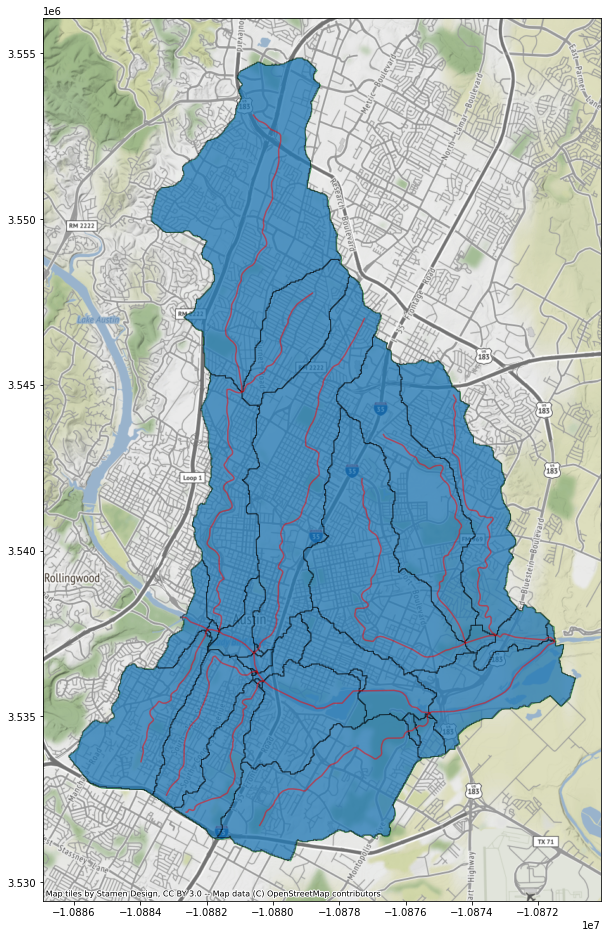

In [63]:
f, ax = plt.subplots(figsize=(10,catchshu12shape.shape[1]/catchshu12shape.shape[0]*10))
catchshu12shape.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(10,catchshu12shape.shape[1]/catchshu12shape.shape[0]*10),
    alpha=.5,
    edgecolor='k'
)
flowshu12shape.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(10,catchshu12shape.shape[1]/catchshu12shape.shape[0]*10),
    alpha=.5,
    edgecolor='r'
)
ctx.add_basemap(ax)
plt.show()

## Buffer the HUC12 catchments

Create new HUC12 boundaries from the catchments pertaining to them

In [65]:
hu12catchs = catchshu12shape.dissolve(by='HUC12')

Find the appropriate metres-based coordinate reference system (CRS)

In [66]:
if hu12catchs.crs.datum.name=='World Geodetic System 1984':
    crs = 'epsg:32614'
elif hu12catchs.crs.datum.name=='North American Datum 1983' or hu12catchs.crs.datum.name=='D_NORTH_AMERICAN_1983' or hu12catchs.crs.datum.name=='NAD83 (National Spatial Reference System 2011)':
    crs = 'epsg:6343'
else:
    raise(TypeError("Non-WGS/NAD datum not yet supported"))

Do the actual buffering in this CRS

In [67]:
if args.buffer:
    hu12catchs['geometry'] = hu12catchs.to_crs(crs).buffer(args.buffer)
else:
    hu12catchs['geometry'] = hu12catchs.to_crs(crs).buffer(500.)
hu12catchs.crs = crs

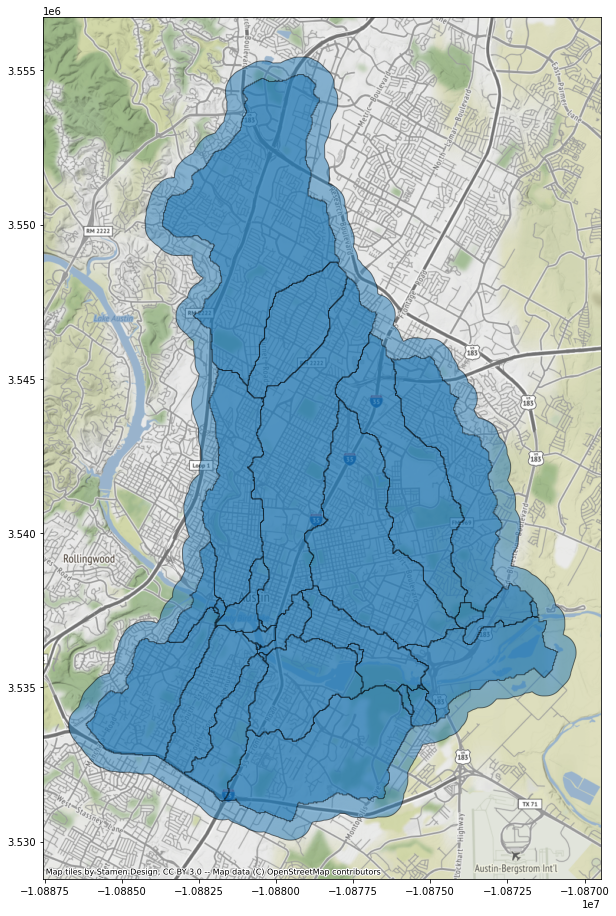

In [69]:
f, ax = plt.subplots(figsize=(10,hu12catchs.shape[1]/hu12catchs.shape[0]*10))
hu12catchs.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(10,hu12catchs.shape[1]/hu12catchs.shape[0]*10),
    alpha=.5,
    edgecolor='k'
)
catchshu12shape.to_crs(epsg=3857).plot(
    ax=ax,
    figsize=(10,hu12catchs.shape[1]/hu12catchs.shape[0]*10),
    alpha=.5,
    edgecolor='k'
)
ctx.add_basemap(ax)
plt.show()

## Output the buffered DEM raster

Reproject the flowlines and catchments to the same CRS

In [70]:
flowshu12shape.to_crs(crs,inplace=True)
catchshu12shape.to_crs(crs,inplace=True)

Use this CRS as the output CRS for raster products

In [71]:
dst_crs = rasterio.crs.CRS.from_dict(init=crs)

Define the output directory location

In [72]:
prefix = os.path.splitext(os.path.basename(args.shapefile))[0]
subdirectory = os.path.join(args.directory, prefix+'-'+str(hu))
Path(subdirectory).mkdir(parents=True, exist_ok=True)

We will be checking the source raster's resolution to ensure it is at least 10m

In [73]:
def append_check(var,subdirectory,hu):

    if any(np.float16(i) > 10. for i in var.res):
        raise(TypeError('>10m raster input for HUC12: {hu}'.format(hu=repe(hu))))

Reproject the source raster, if projection differs from our desired projection

In [120]:
memfile = {}
memfile['dst'] = MemoryFile()
with rasterio.open(args.raster) as src:
    in_image = src.read()
    transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds
    )
    in_meta = src.meta.copy()
    out_meta = src.meta.copy()
    out_meta.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    ## Don't do an expensive reprojection if projection already correct
    if src.meta==out_meta:
        append_check(src,subdirectory,hu)
    else:
        dst = memfile['dst'].open(**out_meta)
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst.transform,
                dst_crs=dst.crs,
                resampling=Resampling.nearest
            )
            append_check(dst,subdirectory,hu)

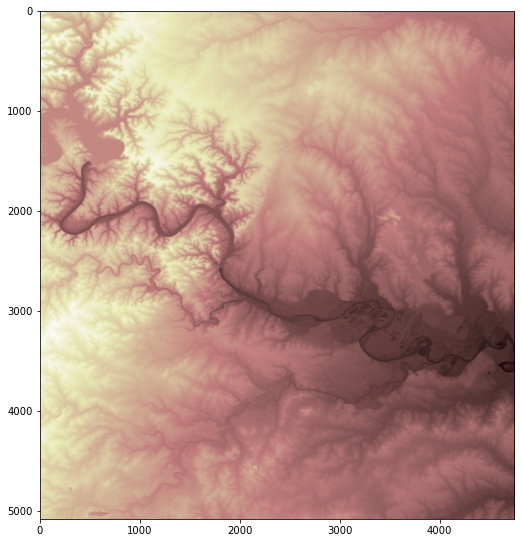

In [121]:
f, ax = plt.subplots(figsize=(10,in_image.squeeze().shape[1]/in_image.squeeze().shape[0]*10))
plt.imshow(ma.masked_array(in_image.squeeze(), mask=in_image.squeeze()==in_meta['nodata']), cmap='pink')
#rasterio.plot.show(ma.masked_array(out_image.squeeze(), mask=out_image.squeeze()==out_meta['nodata']))
plt.show()

In [95]:
print(dst.crs==hu12catchs.crs)

True


Create a list of catchment geometries for the cropping step

In [75]:
hu_buff_geom = list(hu12catchs['geometry'])

Crop and output the raster to the buffered catchments of the HUC

In [98]:
memfile['dataset'] = MemoryFile()
with memfile['dataset'].open(**out_meta) as dataset:
    with memfile['dst'].open(**out_meta) as dst:
        print(np.unique(dst.read()))
        dataset.write(dst.read())
with memfile['dataset'].open(**out_meta) as dataset:
    out_image, out_trans = rasterio.mask.mask(dataset,hu_buff_geom,crop=True)

print(np.unique(out_image))

out_meta.update({
    "height": out_image.shape[1],
    "width":out_image.shape[2],
    "transform": out_trans
})
    
path_elevation = os.path.join(subdirectory, 'Elevation.tif')
file_elevation = Path(path_elevation)
if file_elevation.is_file():
    file_elevation.unlink()
    
with rasterio.open(path_elevation,"w",**out_meta) as dst:
    dst.write(out_image)

[-9999.         110.27       110.270004 ...   359.3902     359.4145
   359.4349  ]
[-9999.         113.7714     113.772415 ...   336.9851     337.0573
   337.1564  ]


In [108]:
import rasterio.plot

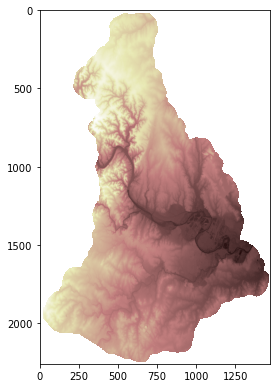

In [117]:
f, ax = plt.subplots(figsize=(10,out_image.squeeze().shape[1]/out_image.squeeze().shape[0]*10))
plt.imshow(ma.masked_array(out_image.squeeze(), mask=out_image.squeeze()==out_meta['nodata']), cmap='pink')
#rasterio.plot.show(ma.masked_array(out_image.squeeze(), mask=out_image.squeeze()==out_meta['nodata']))
plt.show()

Reset the $GDAL_DATA environment variable we modified for this session

In [131]:
os.environ['GDAL_DATA'] = oldgdal_data

In [ ]:
## TODO: Now expand on how to do the above for anywhere else in
##  Texas, referencing the locations of these inputs on Stampede2
## TODO: and how to do it outside of Texas by downloading the source DEM data from the National Map